<a href="https://colab.research.google.com/github/solobala/ABD26/blob/main/ABD26_%D0%9B%D0%B0%D0%B1%D0%B0_PySpark.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Дан набор данных по оттоку клиентов. Набор данных содержит всего 5 000 записей (т.е. абонентов). Данные доступны тут - https://drive.google.com/open?id=1ArslqEEno2hrr5tAs25P0JN0P-coLcFD Перечень полей: state – штат; account length – абонентский стаж; area code – код региона; phone number – номер телефона; international plan – тарифный план для международных звонков; voice mail plan – тарифный план для голосовой почты; number vmail messages – количество сообщений голосовой почты; total day minutes – общая длительность звонков в дневное время (мин); total day calls – общее количество звонков в дневное время; total day charge – общая стоимость звонков в дневное время; total eve minutes – общая длительность звонков в вечернее время (мин); total eve calls – общее количество звонков в вечернее время; total eve charge – общая стоимость звонков в вечернее время; total night minutes – общая длительность звонков в ночное время (мин); total night calls – общее количество звонков в ночное время; total night charge – общая стоимость звонков в ночное время; total intl minutes – общая длительность международных звонков (мин); total intl calls – общее количество международных звонков; total intl charge – общая стоимость международных звонков; number customer service calls – количество звонков в службу поддержки. churned – покинул ли клиент компанию Google Docs churn.csv Ваша задача используя pandas или pyspark ответить на следующие вопросы:

Построить гистограмму количества звонков в техническую поддержку Рассчитать и построить гистограмму общей длительности звонков клиента (дневных + ночных + вечерних + международны) Собственноручно (не используя встроенных функций) рассчитать линейный коэффициент корреляции (https://ru.wikipedia.org/wiki/Корреляция) общего количества минут и количества звонков в техподдержку Визуализировать точечный график по общему количеству минут / количеству звонков в поддержку, подкрасив точки в зависимости от оттока абонента Вывести top-5 самых много и самых мало говорящих клиентов Вывести долю оттока клиентов и среднюю стоимость минуты дневного времени разговора в зависимости от штата перевести штат в one-hot формат при помощи pandas-функции get_dummies или удалите колонку, если вы делаете решение на pyspark Разбить данные на множество для обучения и для проверки, отобрав признаки для обучения модели классификации (убрать номер телефона, код региона, признаки планов + все добавленные аттрибуты) Обучить какую-нибудь модель классификации и оценить качество (точность) на отложенной выборке %D0%9A%D0%BE%D1%80%D1%80%D0%B5%D0%BB%D1%8F%D1%86%D0%B8%D1%8F

# Установка PySpark

In [1]:
# Установка PySpark
!apt-get update > /dev/null

In [2]:
!apt-get install openjdk-8-jdk-headless -qq > /dev/null

In [3]:
!wget -q https://dlcdn.apache.org/spark/spark-3.3.1/spark-3.3.1-bin-hadoop3.tgz

In [4]:
!tar -xf spark-3.3.1-bin-hadoop3.tgz

In [5]:
import os
os.environ["JAVA_HOME"] = "/usr/lib/jvm/java-8-openjdk-amd64"
os.environ["SPARK_HOME"] = "/content/spark-3.3.1-bin-hadoop3"

In [6]:
!pip install -q findspark
import findspark

In [7]:
findspark.init()
from pyspark.sql import SparkSession

In [8]:
spark = SparkSession.builder.master("local[*]").getOrCreate()
sc = spark.sparkContext

# Загрузка Датасета

In [255]:
# загрузка файла
df = spark.read.csv('/content/churn.csv', inferSchema=True, header=True)

In [256]:
df.show()

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+------------

# Визуализация и расчеты

(array([1023., 1786., 1127.,  665.,  252.,   96.,   34.,   13.,    2.,
           2.]),
 array([0. , 0.9, 1.8, 2.7, 3.6, 4.5, 5.4, 6.3, 7.2, 8.1, 9. ]),
 <a list of 10 Patch objects>)

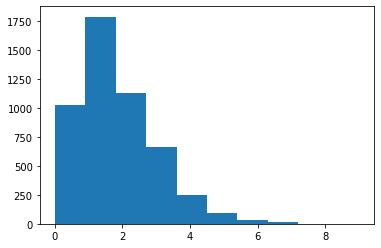

In [197]:
# Построить гистограмму количества звонков в техническую поддержку
import matplotlib.pyplot as plt
number_of_calls = [v.number_customer_service_calls for v in df[['number_customer_service_calls']].collect()]
plt.hist(number_of_calls)

(array([  10.,   88.,  267.,  784., 1206., 1268.,  864.,  381.,  109.,
          23.]),
 array([284.3 , 344.37, 404.44, 464.51, 524.58, 584.65, 644.72, 704.79,
        764.86, 824.93, 885.  ]),
 <a list of 10 Patch objects>)

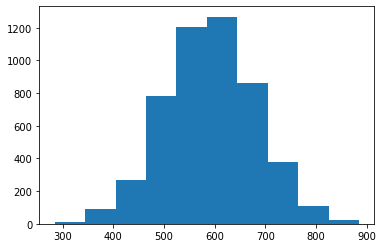

In [198]:
#Рассчитать и построить гистограмму общей длительности звонков клиента (дневных + ночных + вечерних + международны)
total_time = [v.total_day_minutes + v.total_eve_minutes + v.total_night_minutes + v.total_intl_minutes for v in df[['total_day_minutes','total_eve_minutes', 'total_night_minutes', 'total_intl_minutes']].collect()]

df = df.withColumn('total_time', df['total_day_minutes'] + df['total_eve_minutes'] + df['total_night_minutes'] + df['total_intl_minutes'])
plt.hist(total_time)


In [199]:
# Собственноручно (не используя встроенных функций) рассчитать линейный коэффициент корреляции (https://ru.wikipedia.org/wiki/Корреляция) общего количества минут и количества звонков в техподдержку
delta_x = [x - sum(total_time)/len(total_time) for x in total_time] 
mean = sum([v.number_customer_service_calls for v in df[['number_customer_service_calls']].collect()])/len([v.number_customer_service_calls for v in df[['number_customer_service_calls']].collect()])
delta_y =[v.number_customer_service_calls - mean for v in df[['number_customer_service_calls']].collect()] 

chisl = sum([x*y for x,y in zip(delta_x, delta_y)])
from math import sqrt
znam = sqrt(sum([x**2 for x in delta_x]) * sum([y**2 for y in delta_y]))
pirson = chisl/ znam
pirson

-0.01140791082744116

In [200]:
# другой способ
from pyspark.sql.functions import mean as _mean, stddev as _stddev, sum as _sum, sqrt as _sqrt, pow as _pow, col
df_stats = df.select(
    _mean(col('total_time')).alias('mean_calls'),
    _mean(col('number_customer_service_calls')).alias('mean_service')
).collect()

df_stats[0]

Row(mean_calls=591.5788600000038, mean_service=1.5704)

In [201]:
mean_calls = df_stats[0]['mean_calls']
mean_service = df_stats[0]['mean_service']

In [202]:
df.select( (_sum( (col('total_time') - mean_calls) * (col('number_customer_service_calls') - mean_service ) ) /  _sqrt( _sum( _pow(col('total_time') - mean_calls, 2) ) * _sum( _pow(col('number_customer_service_calls') - mean_service, 2) ) )).alias('r')).collect()

[Row(r=-0.01140791082744116)]

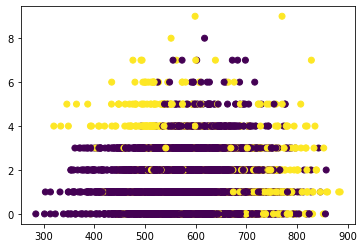

In [203]:
# Визуализировать точечный график по общему количеству минут / количеству звонков в поддержку, подкрасив точки в зависимости от оттока абонента
plt.scatter(total_time, df[['number_customer_service_calls']].collect(), c=df[['churned']].collect())

In [204]:
# Вывести top-5 самых много и самых мало говорящих клиентов
df.createOrReplaceTempView('power')
spark.sql('SELECT * FROM power  order by total_time limit 5').show()


+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+------------------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|        total_time|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------

In [205]:
spark.sql('SELECT phone_number, total_time FROM power group by phone_number, total_time order by total_time DESC limit 5').show()

+------------+-----------------+
|phone_number|       total_time|
+------------+-----------------+
|    345-9140|884.9999999999999|
|    352-6976|882.1999999999999|
|    345-3787|860.1999999999999|
|    410-3888|858.1999999999999|
|    370-4667|857.3999999999999|
+------------+-----------------+



In [206]:
# Другой способ
df.orderBy('total_time', ascending=False).show(5)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+-----------------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|       total_time|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+--------------

In [207]:
df.orderBy('total_time').show(5)

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+------------------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|        total_time|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------

In [258]:
# Вывести долю оттока клиентов и среднюю стоимость минуты дневного времени разговора в зависимости от штата
from pyspark.sql import functions as F
df = df.withColumn('churned_int', col('churned').cast('int')) # добавляем колонку чтобы сохранить boolean знаяения Churned как целые
df.groupBy('state').agg(F.avg(df.total_day_charge/df.total_day_minutes).alias('avg'), F.avg(df.churned_int)).orderBy('state').show()


+-----+-------------------+-------------------+
|state|                avg|   avg(churned_int)|
+-----+-------------------+-------------------+
|   AK| 0.1700015214047099|0.06944444444444445|
|   AL| 0.1700013329716803|0.10483870967741936|
|   AR| 0.1700026921458431|0.17391304347826086|
|   AZ|0.17000187550447118|0.10112359550561797|
|   CA|0.17000349532173592| 0.2692307692307692|
|   CO|0.17000249581284835|0.11458333333333333|
|   CT| 0.1700016593171857|0.16161616161616163|
|   DC|0.17000856850114776|0.10227272727272728|
|   DE|0.17000515533395988| 0.1595744680851064|
|   FL|0.17000128818261162|0.13333333333333333|
|   GA|0.17000285296030704|0.12048192771084337|
|   HI|0.16999966083809578|0.05813953488372093|
|   IA|0.17000844477675295|0.11594202898550725|
|   ID|0.17000328448548618|0.11764705882352941|
|   IL| 0.1700037716584672|0.07954545454545454|
|   IN|0.16999955151681176|0.14285714285714285|
|   KS| 0.1700027862649722|0.18181818181818182|
|   KY|0.17000800973759486|0.15151515151

# Сохранение датасета с добавленной колонкой churned_int для обработки в pipeline

In [259]:
df_for_pipeline = df

# Обработка датасета (подготовка признаков) вручную

In [260]:
# перевести признак ухода клиента и штат в one-hot формат 
from pyspark.ml.feature import StringIndexer, OneHotEncoder
# label_indexer = StringIndexer(inputCol='churned', outputCol='label') Разве StringIndexer работает с boolean?
indexer = StringIndexer(inputCol='state', outputCol='stateInd')
indexerTrained = indexer.fit(df)
df = indexerTrained.transform(df)
df.show()

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+-----------+--------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|churned_int|stateInd|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+--------

In [261]:
ohe = OneHotEncoder(inputCol='stateInd', outputCol='state_Ohe')
ohe = ohe.fit(df) # Все-таки нужен Fit
df = ohe.transform(df)
df.show() # в state_Ohe 1 число - обьщее к-во колонок=к-во штатов -1, 2-е - номер колонки, где 1, 3 -е - непорседствееео 1

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+-----------+--------+---------------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|churned_int|stateInd|      state_Ohe|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+--------------

In [262]:
# теперь все признаки для построения модели соберем в вектор features
from pyspark.ml.linalg import Vectors
from pyspark.ml.feature import VectorAssembler
cols=['account_length', 'number_vmail_messages', 'total_day_minutes',
       'total_day_calls', 'total_day_charge', 'total_eve_minutes',
       'total_eve_calls', 'total_eve_charge', 'total_night_minutes',
       'total_night_calls', 'total_night_charge', 'total_intl_minutes',
       'total_intl_calls', 'total_intl_charge',
       'number_customer_service_calls', 'state_Ohe']
assembler = VectorAssembler(inputCols = cols, outputCol = 'features')

df_features = assembler.transform(df)


In [263]:
df_features.show()

+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+---------------+----------------+-------------------+-----------------+------------------+------------------+----------------+-----------------+-----------------------------+-------+-----------+--------+---------------+--------------------+
|state|account_length|area_code|phone_number|international_plan|voice_mail_plan|number_vmail_messages|total_day_minutes|total_day_calls|total_day_charge|total_eve_minutes|total_eve_calls|total_eve_charge|total_night_minutes|total_night_calls|total_night_charge|total_intl_minutes|total_intl_calls|total_intl_charge|number_customer_service_calls|churned|churned_int|stateInd|      state_Ohe|            features|
+-----+--------------+---------+------------+------------------+---------------+---------------------+-----------------+---------------+----------------+-----------------+-----

In [264]:
# Уберем лишние колонки, которые не используются как признаки. в начало добавим churned_int, т.к. с boolean churned модель не работает. Это делать не обязательно
df_features = df_features.select('churned_int', 'features')

In [265]:
df_features.show() # и это тоже

+-----------+--------------------+
|churned_int|            features|
+-----------+--------------------+
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          1|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          1|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
+-----------+--------------------+
only showing top 20 rows



# Машинное обучение

In [266]:
train, test = df_features.randomSplit([0.8, 0.2], seed=12345)

In [267]:
train.show()

+-----------+--------------------+
|churned_int|            features|
+-----------+--------------------+
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
+-----------+--------------------+
only showing top 20 rows



In [268]:
from pyspark.ml.classification import LogisticRegression

In [287]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'churned_int')
lrModel = lr.fit(train)

In [288]:
train_res = lrModel.transform(train)
test_res = lrModel.transform(test)

In [271]:
train_res.show()

+-----------+--------------------+--------------------+--------------------+----------+
|churned_int|            features|       rawPrediction|         probability|prediction|
+-----------+--------------------+--------------------+--------------------+----------+
|          0|(65,[0,1,2,3,4,5,...|[3.46863975271165...|[0.96978218233609...|       0.0|
|          0|(65,[0,1,2,3,4,5,...|[-1.0164434650470...|[0.26572074912064...|       1.0|
|          0|(65,[0,1,2,3,4,5,...|[0.77272474834939...|[0.68411001656716...|       0.0|
|          0|(65,[0,1,2,3,4,5,...|[0.65993849895258...|[0.65924657295887...|       0.0|
|          0|(65,[0,1,2,3,4,5,...|[1.74190558461499...|[0.85092894841022...|       0.0|
|          0|(65,[0,1,2,3,4,5,...|[1.98489332363255...|[0.87920182739657...|       0.0|
|          0|(65,[0,1,2,3,4,5,...|[0.49166936091667...|[0.62049961219013...|       0.0|
|          0|(65,[0,1,2,3,4,5,...|[1.34948388394276...|[0.79404523673084...|       0.0|
|          0|(65,[0,1,2,3,4,5,..

In [272]:
# Для оценки качества предсказания в spark реализованно несколько классов 
# Если мы решаем задачу бинарной классификации (то есть классов - 2), то нам подойдет BinaryCLassificationEvaluator, 
# а если классов больше 2-х, то MulticlassClassificationEvaluator
from pyspark.ml.evaluation import BinaryClassificationEvaluator
ev = BinaryClassificationEvaluator(labelCol='churned_int')
ev.evaluate(train_res)

0.7850295989894243

In [273]:
ev.evaluate(test_res)

0.7524785599464756

In [274]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(labelCol = 'churned_int', featuresCol = 'features')
cls=classifier.fit(train)

In [276]:
train_res = cls.transform(train)
test_res = cls.transform(test)

In [277]:
ev.evaluate(train_res)

0.878127347897525

In [278]:
ev.evaluate(test_res)

0.861233282470158

# Автоматизация подготовки данных с помощью pipeline

In [280]:
from pyspark.ml import Pipeline


In [281]:
# Это описаниек трубопровода
pipeline = Pipeline(stages = 
[
  StringIndexer(inputCol='state', outputCol='stateInd'), # Кодирование штатов - замена аббревиатур на числа
  OneHotEncoder(inputCol='stateInd', outputCol='state_Ohe'), # преобразование в разреженные вектора с помощью OneHotEncoder
  VectorAssembler(inputCols=cols, outputCol='features'), # сбор отобранных признаков, названия которых перечислены в списке Cols, в вектор features
  LogisticRegression(featuresCol = 'features', labelCol = 'churned_int') # Создание экземпляра выбранной модели и загрузка в нее названий столбца признаков и столбца таргета
]
)


In [282]:
# А это передача исходного датафрейма в трубопровод
pipelineTrained = pipeline.fit(df_for_pipeline) 

In [284]:
ddf= pipelineTrained.transform(df_for_pipeline).select('churned_int','features')
ddf.show()

+-----------+--------------------+
|churned_int|            features|
+-----------+--------------------+
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          1|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,2,3,4,5,6,...|
|          1|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
|          0|(65,[0,1,2,3,4,5,...|
|          0|(65,[0,2,3,4,5,6,...|
+-----------+--------------------+
only showing top 20 rows



In [285]:
train, test = ddf.randomSplit([0.8, 0.2], seed=12345)

In [289]:
lr = LogisticRegression(featuresCol = 'features', labelCol = 'churned_int')
lrModel = lr.fit(train)

In [290]:
train_res = lrModel.transform(train)
test_res = lrModel.transform(test)

In [291]:
ev.evaluate(train_res)

0.7850295989894243

In [292]:
ev.evaluate(test_res)

0.7524785599464756

In [293]:
from pyspark.ml.classification import RandomForestClassifier
classifier = RandomForestClassifier(labelCol = 'churned_int', featuresCol = 'features')
cls=classifier.fit(train)

In [294]:
train_res = cls.transform(train)
test_res = cls.transform(test)

In [295]:
ev.evaluate(train_res)

0.878127347897525

In [296]:
ev.evaluate(test_res)

0.861233282470158